<a href="https://colab.research.google.com/github/natsakh/IAD/blob/main/Pr_6/6_5_LSTM_IMDB_Glove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')

import matplotlib.pyplot as plt
import numpy as np
import re, string
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import random

torch.manual_seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Device: cpu


In [2]:
# Hugging Face Datasets — бібліотека для завантаження датасетів.
#У Google Colab вона вже попередньо встановлена
# Якщо ви працюєте локально — попередньо виконайте:
#     pip install datasets
from datasets import load_dataset
#https://huggingface.co/datasets

In [3]:
ds = load_dataset("imdb")
#ds["train"], ds["test"]
#список словників — кожен елемент має ключі 'text' і 'label'

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [4]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [5]:
example = ds["train"][0]
print('text: ', example['text'])
print('label: ', example['label'])
#label = 1 → позитивний відгук, 0 → негативний.

text:  I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far betwe

In [6]:
def clean_text(text):
    text = text.lower()                                       # до нижнього регістру
    text = re.sub(r"@\S+", " ", text)                         # прибрати згадки @user
    text = re.sub(r"http\S+", " ", text)                      # прибрати посилання
    text = re.sub(r"[^a-z\s]", " ", text)                     # залишити лише букви (прибрати цифри, спецсимволи)
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)  # прибрати пунктуацію
    text = re.sub(r"\s+", " ", text)                          # замінити багато пробілів на один
    return text

In [7]:
cleaned_texts = [clean_text(ex["text"]) for ex in ds["train"]]
tokens = [word_tokenize(t) for t in cleaned_texts]

In [8]:
counter = Counter()
for tok_list in tokens:
    counter.update(tok_list)

In [9]:
# кількість унікальних слів
vocab_size = len(counter)

print(f"Кількість унікальних слів у train-наборі: {vocab_size:,}")

Кількість унікальних слів у train-наборі: 73,206


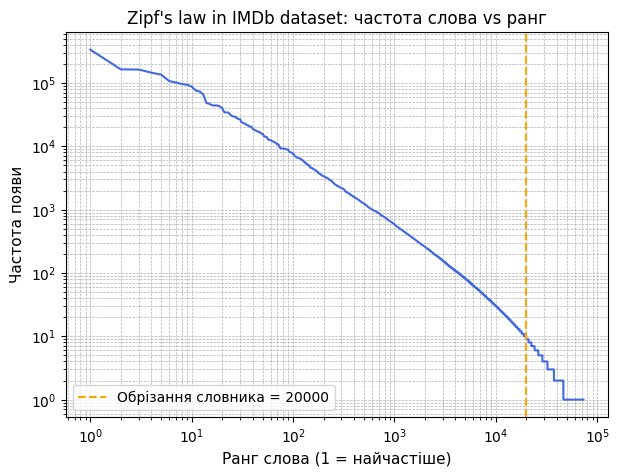

In [10]:
word_freqs = np.array(sorted(counter.values(), reverse=True))
ranks = np.arange(1, len(word_freqs) + 1)

plt.figure(figsize=(7, 5))
plt.loglog(ranks, word_freqs, color='royalblue')
plt.title("Zipf's law in IMDb dataset: частота слова vs ранг", fontsize=12)
plt.xlabel("Ранг слова (1 = найчастіше)", fontsize=11)
plt.ylabel("Частота появи", fontsize=11)
plt.grid(True, which="both", ls="--", lw=0.5)

 # обмежимо словник
MAX_VOCAB = 20_000
plt.axvline(MAX_VOCAB, color='orange', linestyle='--', label=f'Обрізання словника = {MAX_VOCAB}')
plt.legend()

plt.show()


In [11]:
# створюємо списки перетворень, створюємо словник
specials = ["<pad>", "<unk>"]
most_common = counter.most_common(MAX_VOCAB - len(specials))
itos = specials + [w for w, _ in most_common]       # index → string
stoi = {w: i for i, w in enumerate(itos)}           # string → index

PAD_IDX = stoi["<pad>"]
UNK_IDX = stoi["<unk>"]

print("Розмір словника:", len(stoi))
print("Приклад індексу:", stoi.get("movie", UNK_IDX))

Розмір словника: 20000
Приклад індексу: 19


In [12]:
#кодуємо тексти у послідовності індексів
#для кожного токена беремо його індекс зі словника stoi,
#якщо слова немає — повертаємо індекс UNK_IDX.
def encode(tokens):
    return [stoi.get(t, UNK_IDX) for t in tokens]

encoded_texts = [encode(tok_list) for tok_list in tokens]
print(encoded_texts[0][:20])


[11, 1595, 11, 240, 1973, 4046, 39, 61, 367, 1098, 87, 5, 32, 2, 6975, 13, 3357, 9, 55, 9]


In [13]:
#Padding (вирівнюємо довжину)
#Нейронна мережа очікує тензори однакової довжини,
#тому короткі тексти “доповнюємо” <pad>, а надто довгі — обрізаємо

MAX_LEN = 100   # довжина послідовності
def pad_sequence(seq):
    seq = seq[:MAX_LEN] + [PAD_IDX] * max(0, MAX_LEN - len(seq))
    return torch.tensor(seq, dtype=torch.long)

X = torch.stack([pad_sequence(seq) for seq in encoded_texts])
print(X.shape)   # [N, MAX_LEN]


torch.Size([25000, 100])


In [14]:
# мітки (labels)
y = torch.tensor([ex["label"] for ex in ds["train"]], dtype=torch.float32)
print(y.shape)   # [N]

torch.Size([25000])


In [15]:
#TensorDataset і DataLoader
dataset = TensorDataset(X, y)

# розділяємо на train/val
VAL_FRAC = 0.2
val_sz = int(len(dataset) * VAL_FRAC)
train_sz = len(dataset) - val_sz
train_ds, val_ds = random_split(dataset, [train_sz, val_sz],
                                generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=128)


In [16]:
# використовуємо ті самі clean_text, токенайзер/word_tokenize, stoi, PAD_IDX, MAX_LEN

# Підготовка X_test, y_test
cleaned_test = [clean_text(ex["text"]) for ex in ds["test"]]
tokens_test  = [word_tokenize(t) for t in cleaned_test]
encoded_test = [[stoi.get(tok, UNK_IDX) for tok in toks] for toks in tokens_test]

def pad_sequence(seq):
    seq = seq[:MAX_LEN] + [PAD_IDX] * max(0, MAX_LEN - len(seq))
    return torch.tensor(seq, dtype=torch.long)

X_test = torch.stack([pad_sequence(seq) for seq in encoded_test])
y_test = torch.tensor([ex["label"] for ex in ds["test"]], dtype=torch.float32)

# 2) TensorDataset + DataLoader
test_ds = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)  # на тесті shuffle=False


In [17]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    train_loss = 0.0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(loader)

    return train_loss


In [18]:
def evaluate_one_epoch(model, loader, criterion, device):
    model.eval()
    valid_loss = 0.0

    with torch.no_grad():
      for x, y in loader:
          x, y = x.to(device), y.to(device)
          out = model(x)
          loss = criterion(out, y)
          valid_loss += loss.item()
    valid_loss /= len(loader)

    return valid_loss

In [19]:
class BiLSTM_IMDB(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, pad_idx,
                 num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)

        self.lstm = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_dim * 2, 1)   # *2 бо BiLSTM

    def forward(self, x):
        # x: [batch, seq_len] з падінгом pad_idx
        x = self.embedding(x)     # [B, T, emb_dim]

        out, (h, c) = self.lstm(x)
        # h: [num_layers*2, B, hidden_dim]
        # беремо останній шар: forward = -2, backward = -1
        h_fwd = h[-2, :, :]
        h_bwd = h[-1, :, :]
        h_cat = torch.cat([h_fwd, h_bwd], dim=1) # [B, 2*hidden_dim]

        logits = self.fc(h_cat)   # [B, 1]
        return logits.squeeze(1)                 # [B]


In [20]:
vocab_size = len(stoi)
emb_dim = 100
hidden_dim = 64
pad_idx = stoi["<pad>"]

model_basic = BiLSTM_IMDB(vocab_size, emb_dim, hidden_dim, pad_idx).to(device)
print(model_basic)


BiLSTM_IMDB(
  (embedding): Embedding(20000, 100, padding_idx=0)
  (lstm): LSTM(100, 64, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


nn.Embedding(vocab_size, emb_dim) — створює матрицю розміром [vocab_size × emb_dim], де кожне слово отримує свій вектор.
pad_idx гарантує, що <pad> завжди отримає нульовий вектор і не впливатиме на навчання.


Функція втрат для бінарної класифікації
nn.BCEWithLogitsLoss() — всередині вже має сигмоїду,
тому у моделі НЕ ставимо nn.Sigmoid() перед виходом.
Якщо замість неї використовувати nn.BCELoss(),
тоді потрібно ДОДАТИ сигмоїду (наприклад, torch.sigmoid або nn.Sigmoid).


In [21]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_basic.parameters(), lr=1e-3)

In [22]:
# навчання
n_epochs = 7

for epoch in range(n_epochs):
   train_loss = train_one_epoch(model_basic, train_loader, optimizer, criterion, device)
   val_loss = evaluate_one_epoch(model_basic, val_loader, criterion, device)

   print(f"[{epoch+1:02d}] train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")

[01] train_loss=0.6733 | val_loss=0.6261
[02] train_loss=0.5406 | val_loss=0.5321
[03] train_loss=0.4194 | val_loss=0.4974
[04] train_loss=0.3588 | val_loss=0.4647
[05] train_loss=0.2771 | val_loss=0.4650
[06] train_loss=0.2236 | val_loss=0.4971
[07] train_loss=0.1725 | val_loss=0.5144


In [25]:
# Для фінальної перевірки якості
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, total_acc, n = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)
        preds = (torch.sigmoid(logits) >= 0.5).long()
        total_loss += loss.item() * xb.size(0)
        total_acc  += (preds == yb.long()).sum().item()
        n += xb.size(0)
    return total_loss/n, total_acc/n

In [26]:
test_loss, test_acc = evaluate(model_basic, test_loader, criterion, device)
print(f"TEST  loss={test_loss:.4f}  acc={test_acc*100:.2f}%")

TEST  loss=0.5613  acc=78.21%


#Glove

In [27]:
!wget -q http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

у папці будуть файли: glove.6B.50d.txt, glove.6B.100d.txt, glove.6B.200d.txt, glove.6B.300d.txt

візьмемо glove.6B.100d.txt

GloVe — всі слова в lowercase, не прибираються стоп-слова;

не виконується лематизація чи стемінг.



In [28]:
#читаємо файл у словник word -> vector
def load_glove_txt(path):
    vectors = {}
    with open(path, "r", encoding="utf8") as f:
        for line in f:
            parts = line.rstrip().split(" ")
            word = parts[0]
            vec = np.asarray(parts[1:], dtype=np.float32)
            vectors[word] = vec
    dim = len(next(iter(vectors.values())))
    return vectors, dim

glove_path = "glove.6B.100d.txt"
glove, emb_dim = load_glove_txt(glove_path)
print("GloVe dim:", emb_dim, "| entries:", len(glove))


GloVe dim: 100 | entries: 400000


In [29]:
#приклад embeddings
for w in ["the", "movie", "love", "bad"]:
    print(w, glove[w][:10])  # перші 10 компонент

the [-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459]
movie [ 0.38251   0.14821   0.60601  -0.51533   0.43992   0.061053 -0.62716
 -0.025385  0.1643   -0.22101 ]
love [ 0.25975   0.55833   0.57986  -0.21361   0.13084   0.94385  -0.42817
 -0.3742   -0.094499 -0.43344 ]
bad [ 0.39456  -0.24717   1.0319   -0.61444  -1.2376    0.051794 -0.55112
 -0.31014  -0.025735 -0.24709 ]


збираємо embedding-матрицю під наш словник stoi

In [30]:
vocab_size = len(stoi)
PAD_IDX = stoi["<pad>"]
UNK_IDX = stoi["<unk>"]

emb_matrix = np.random.normal(scale=0.1, size=(vocab_size, emb_dim)).astype(np.float32)
emb_matrix[PAD_IDX] = 0.0  # пад завжди нульовий

hit = 0
for w, idx in stoi.items():
    v = glove.get(w)                      # w має бути в lower()
    if v is not None:
        emb_matrix[idx] = v
        hit += 1
print(f"Coverage: {hit}/{vocab_size} = {hit/vocab_size:.1%}")


Coverage: 19856/20000 = 99.3%


In [31]:
pretrained_emb = nn.Embedding.from_pretrained(
    torch.tensor(emb_matrix),
    freeze=True,                #заморозити
    padding_idx=PAD_IDX
)
emb_dim= 100
model_tl = BiLSTM_IMDB(vocab_size, emb_dim, hidden_dim, pad_idx).to(device)
# Підміняємо шар у моделі
model_tl.embedding = pretrained_emb


In [32]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_tl.parameters(), lr=1e-3)

In [33]:
# навчання
n_epochs = 7

for epoch in range(n_epochs):
   train_loss = train_one_epoch(model_tl, train_loader, optimizer, criterion, device)
   val_loss = evaluate_one_epoch(model_tl, val_loader, criterion, device)

   print(f"[{epoch+1:02d}] train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")

[01] train_loss=0.6566 | val_loss=0.6318
[02] train_loss=0.6058 | val_loss=0.5387
[03] train_loss=0.5279 | val_loss=0.5134
[04] train_loss=0.4837 | val_loss=0.4748
[05] train_loss=0.4586 | val_loss=0.4410
[06] train_loss=0.4371 | val_loss=0.4237
[07] train_loss=0.4156 | val_loss=0.4121


In [34]:
test_loss, test_acc = evaluate(model_tl, test_loader, criterion, device)
print(f"TEST  loss={test_loss:.4f}  acc={test_acc*100:.2f}%")

TEST  loss=0.4274  acc=79.96%
